In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
prev_days = 5 # Number of previous days to feed in model
forecast_days = 2 # Number of days for which u want to carry out forecast

prev_hrs = prev_days * 24 #converting days to hrs
forecast_hrs = forecast_days * 24 

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from keras import metrics
from keras.models import load_model
from keras.models import Sequential
from keras.models import Model

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers import Input

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [6]:
dataset = pd.read_csv('/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/Dipam/data/continuous_dataset.csv')
dataset['datetime'] = pd.to_datetime(dataset['datetime'])
print(dataset.head())

             datetime  nat_demand    T2M_toc  ...  Holiday_ID  holiday  school
0 2015-01-03 01:00:00    970.3450  25.865259  ...           0        0       0
1 2015-01-03 02:00:00    912.1755  25.899255  ...           0        0       0
2 2015-01-03 03:00:00    900.2688  25.937280  ...           0        0       0
3 2015-01-03 04:00:00    889.9538  25.957544  ...           0        0       0
4 2015-01-03 05:00:00    893.6865  25.973840  ...           0        0       0

[5 rows x 17 columns]


In [7]:
true_forecast = pd.read_csv('/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/Dipam/data/weekly_pre_dispatch_forecast.csv')
true_forecast['datetime'] = pd.to_datetime(true_forecast['datetime'])
print(true_forecast.head())

             datetime  load_forecast
0 2016-01-02 00:00:00         1056.9
1 2016-01-02 01:00:00         1057.1
2 2016-01-02 02:00:00          996.5
3 2016-01-02 03:00:00          955.8
4 2016-01-02 04:00:00          918.0


In [8]:
data = pd.merge(dataset, true_forecast, how="inner", on="datetime")
print(data.head())

             datetime  nat_demand    T2M_toc  ...  holiday  school  load_forecast
0 2016-01-02 00:00:00   1004.4597  26.080133  ...        0       0         1056.9
1 2016-01-02 01:00:00    978.7889  25.960718  ...        0       0         1057.1
2 2016-01-02 02:00:00    954.4416  25.864252  ...        0       0          996.5
3 2016-01-02 03:00:00    915.8370  25.832788  ...        0       0          955.8
4 2016-01-02 04:00:00    915.0010  25.781274  ...        0       0          918.0

[5 rows x 18 columns]


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39313 entries, 0 to 39312
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       39313 non-null  datetime64[ns]
 1   nat_demand     39313 non-null  float64       
 2   T2M_toc        39313 non-null  float64       
 3   QV2M_toc       39313 non-null  float64       
 4   TQL_toc        39313 non-null  float64       
 5   W2M_toc        39313 non-null  float64       
 6   T2M_san        39313 non-null  float64       
 7   QV2M_san       39313 non-null  float64       
 8   TQL_san        39313 non-null  float64       
 9   W2M_san        39313 non-null  float64       
 10  T2M_dav        39313 non-null  float64       
 11  QV2M_dav       39313 non-null  float64       
 12  TQL_dav        39313 non-null  float64       
 13  W2M_dav        39313 non-null  float64       
 14  Holiday_ID     39313 non-null  int64         
 15  holiday        3931

In [10]:
dataset_final = data.iloc[:,1:]

dataset_final['week_day']=data['datetime'].dt.dayofweek
dataset_final['date']=data['datetime'].dt.day
dataset_final['month']=data['datetime'].dt.month
dataset_final['hour']=data['datetime'].dt.hour

print(dataset_final.info())
print(dataset_final.head())
print(dataset_final.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39313 entries, 0 to 39312
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   nat_demand     39313 non-null  float64
 1   T2M_toc        39313 non-null  float64
 2   QV2M_toc       39313 non-null  float64
 3   TQL_toc        39313 non-null  float64
 4   W2M_toc        39313 non-null  float64
 5   T2M_san        39313 non-null  float64
 6   QV2M_san       39313 non-null  float64
 7   TQL_san        39313 non-null  float64
 8   W2M_san        39313 non-null  float64
 9   T2M_dav        39313 non-null  float64
 10  QV2M_dav       39313 non-null  float64
 11  TQL_dav        39313 non-null  float64
 12  W2M_dav        39313 non-null  float64
 13  Holiday_ID     39313 non-null  int64  
 14  holiday        39313 non-null  int64  
 15  school         39313 non-null  int64  
 16  load_forecast  39313 non-null  float64
 17  week_day       39313 non-null  int64  
 18  date  

In [11]:
dataset_final = dataset_final[['load_forecast', 'nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav', 'W2M_dav', 'Holiday_ID', 'holiday', 'school', 'week_day', 'date', 'month', 'hour']]

In [12]:
print(dataset_final.info())
print(dataset_final.head())
print(dataset_final.tail())

df = dataset_final

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39313 entries, 0 to 39312
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   load_forecast  39313 non-null  float64
 1   nat_demand     39313 non-null  float64
 2   T2M_toc        39313 non-null  float64
 3   QV2M_toc       39313 non-null  float64
 4   TQL_toc        39313 non-null  float64
 5   W2M_toc        39313 non-null  float64
 6   T2M_san        39313 non-null  float64
 7   QV2M_san       39313 non-null  float64
 8   TQL_san        39313 non-null  float64
 9   W2M_san        39313 non-null  float64
 10  T2M_dav        39313 non-null  float64
 11  QV2M_dav       39313 non-null  float64
 12  TQL_dav        39313 non-null  float64
 13  W2M_dav        39313 non-null  float64
 14  Holiday_ID     39313 non-null  int64  
 15  holiday        39313 non-null  int64  
 16  school         39313 non-null  int64  
 17  week_day       39313 non-null  int64  
 18  date  

In [13]:
training_set = df.iloc[0:-(forecast_hrs*2)-prev_hrs,1:]
testing_set = df.iloc[-(forecast_hrs*2)-prev_hrs:,1:]

print("Training Set Information:")
print(training_set.info())
print(training_set.head())

print("\nTraining Set values array:")
training_set_values = training_set.values
print(training_set_values)


print("\n\nTesting Set Information:")
print(testing_set.info())
print(testing_set.head())


print("\nTesting Set values array:")
testing_set_values = testing_set.values
print(testing_set_values)

Training Set Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39097 entries, 0 to 39096
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   nat_demand  39097 non-null  float64
 1   T2M_toc     39097 non-null  float64
 2   QV2M_toc    39097 non-null  float64
 3   TQL_toc     39097 non-null  float64
 4   W2M_toc     39097 non-null  float64
 5   T2M_san     39097 non-null  float64
 6   QV2M_san    39097 non-null  float64
 7   TQL_san     39097 non-null  float64
 8   W2M_san     39097 non-null  float64
 9   T2M_dav     39097 non-null  float64
 10  QV2M_dav    39097 non-null  float64
 11  TQL_dav     39097 non-null  float64
 12  W2M_dav     39097 non-null  float64
 13  Holiday_ID  39097 non-null  int64  
 14  holiday     39097 non-null  int64  
 15  school      39097 non-null  int64  
 16  week_day    39097 non-null  int64  
 17  date        39097 non-null  int64  
 18  month       39097 non-null  int64  
 19 

In [14]:
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_values_scaled = scaler.fit_transform(training_set_values)
testing_set_values_scaled = scaler.fit_transform(testing_set_values)

In [15]:
X_train = []
Y_train = []

for i in range(prev_hrs, len(training_set_values_scaled)-forecast_hrs):
    X_train.append(training_set_values_scaled[i-prev_hrs:i,:])
    Y_train.append(training_set_values_scaled[i:i+forecast_hrs,:])
X_train, Y_train = np.array(X_train), np.array(Y_train)
print(X_train.shape)
print(Y_train.shape)

(38929, 120, 20)
(38929, 48, 20)


In [16]:
X_test = []
Y_test = []
for i in range(prev_hrs, len(testing_set_values_scaled)-forecast_hrs):
    X_test.append(testing_set_values_scaled[i-prev_hrs:i,:])
    Y_test.append(testing_set_values_scaled[i:i+forecast_hrs,:])
X_test, Y_test = np.array(X_test), np.array(Y_test)
print(X_test.shape)
print(Y_test.shape)

(48, 120, 20)
(48, 48, 20)


In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], Y_train.shape[2]))
print(X_train.shape)
print(Y_train.shape)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], Y_test.shape[2]))
print(X_test.shape)
print(Y_test.shape)


(38929, 120, 20)
(38929, 48, 20)
(48, 120, 20)
(48, 48, 20)


In [18]:
encoder_inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
encoder_l1 = LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = RepeatVector(Y_train.shape[1])(encoder_outputs2[0])
#
decoder_l1 = LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = TimeDistributed(Dense(Y_train.shape[2]))(decoder_l2)
#
model = Model(encoder_inputs,decoder_outputs2)

model.compile(optimizer = 'adam', loss='mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 20)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 120, 100),   48400       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  [(None, 100),        80400       ['lstm[0][0]']                   
                                 (None, 100),                                                 

In [19]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb 17 07:50:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    67W / 149W |    147MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
model_stats = model.fit(X_train, Y_train, epochs = 150, batch_size = 2048, validation_split=0.3, validation_batch_size=2048)

Epoch 1/150
14/14 [==============================] - 19s 621ms/step - loss: 0.0910 - val_loss: 0.0500
Epoch 2/150
14/14 [==============================] - 7s 484ms/step - loss: 0.0429 - val_loss: 0.0386
Epoch 3/150
14/14 [==============================] - 7s 492ms/step - loss: 0.0350 - val_loss: 0.0330
Epoch 4/150
14/14 [==============================] - 7s 486ms/step - loss: 0.0310 - val_loss: 0.0305
Epoch 5/150
14/14 [==============================] - 7s 487ms/step - loss: 0.0286 - val_loss: 0.0287
Epoch 6/150
14/14 [==============================] - 7s 490ms/step - loss: 0.0271 - val_loss: 0.0276
Epoch 7/150
14/14 [==============================] - 7s 491ms/step - loss: 0.0261 - val_loss: 0.0265
Epoch 8/150
14/14 [==============================] - 7s 492ms/step - loss: 0.0255 - val_loss: 0.0266
Epoch 9/150
14/14 [==============================] - 7s 489ms/step - loss: 0.0243 - val_loss: 0.0243
Epoch 10/150
14/14 [==============================] - 7s 492ms/step - loss: 0.0227 - val_l

dict_keys(['loss', 'val_loss'])


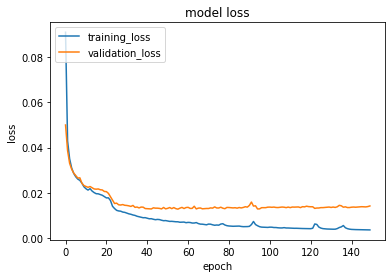

In [21]:
print(model_stats.history.keys())

plt.plot(model_stats.history['loss'])
plt.plot(model_stats.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training_loss', 'validation_loss'], loc='upper left')
plt.show()

In [22]:
model.save("/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/Dipam")
print("Saved model to disk")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/Dipam/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/Dipam/assets


Saved model to disk


In [23]:
model = load_model("/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/Dipam")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 20)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 120, 100),   48400       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  [(None, 100),        80400       ['lstm[0][0]']                   
                                 (None, 100),                                                 

In [24]:
keras_evaluation = model.evaluate(X_test, Y_test)

2/2 [==============================] - 2s 40ms/step - loss: 0.0310


In [25]:
predicted_values = model.predict(X_test)

In [26]:
print(predicted_values.shape)

(48, 48, 20)


In [27]:
predicted_values_t = []
for index , values in enumerate(predicted_values):
    predicted_values_t.append(scaler.inverse_transform(predicted_values[index]))

Y_test_t = []
for index , values in enumerate(Y_test):
    Y_test_t.append(scaler.inverse_transform(Y_test[index]))

print(predicted_values_t[0].shape)
print(Y_test_t[0].shape)
Y_test = np.array(Y_test_t)
predicted_values = np.array(predicted_values_t)
print(Y_test.shape)
print(predicted_values.shape)

(48, 20)
(48, 20)
(48, 48, 20)
(48, 48, 20)


In [28]:
print(Y_test)
print(predicted_values)

[[[1.07838740e+03 2.72314087e+01 2.07533950e-02 ... 2.30000000e+01
   6.00000000e+00 1.00000000e+00]
  [1.04675040e+03 2.71350647e+01 2.06542310e-02 ... 2.30000000e+01
   6.00000000e+00 2.00000000e+00]
  [1.02165180e+03 2.70747314e+01 2.05856100e-02 ... 2.30000000e+01
   6.00000000e+00 3.00000000e+00]
  ...
  [1.19565900e+03 2.73709045e+01 2.07145270e-02 ... 2.40000000e+01
   6.00000000e+00 2.20000000e+01]
  [1.13055670e+03 2.71979614e+01 2.08442270e-02 ... 2.40000000e+01
   6.00000000e+00 2.30000000e+01]
  [1.10261920e+03 2.70678345e+01 2.09205370e-02 ... 2.50000000e+01
   6.00000000e+00 0.00000000e+00]]

 [[1.04675040e+03 2.71350647e+01 2.06542310e-02 ... 2.30000000e+01
   6.00000000e+00 2.00000000e+00]
  [1.02165180e+03 2.70747314e+01 2.05856100e-02 ... 2.30000000e+01
   6.00000000e+00 3.00000000e+00]
  [1.01186810e+03 2.70264832e+01 2.05321870e-02 ... 2.30000000e+01
   6.00000000e+00 4.00000000e+00]
  ...
  [1.13055670e+03 2.71979614e+01 2.08442270e-02 ... 2.40000000e+01
   6.00000

In [29]:
print(Y_test.shape)
print(predicted_values.shape)

mean_squared_error_array=[]
for index in range(Y_test.shape[0]):
    mean_squared_error_array.append(mean_squared_error(Y_test[index,:,0:1],predicted_values[index,:,0:1]))

root_mean_squared_error_array = np.sqrt(np.array(mean_squared_error_array))

print("Median Root Mean Squared Error: ",np.median(root_mean_squared_error_array), "MWh i.e. MegaWattHour")
print("Accuracy Based on Median RMSE ",100-((np.median(root_mean_squared_error_array)/np.max(Y_test))*100),"%")

print("Max Root Mean Squared Error: ",np.max(root_mean_squared_error_array), "MWh i.e. MegaWattHour")
print("Accuracy Based on Max RMSE ",100-((np.max(root_mean_squared_error_array)/np.max(Y_test))*100),"%")

(48, 48, 20)
(48, 48, 20)
Median Root Mean Squared Error:  117.31476261631286 MWh i.e. MegaWattHour
Accuracy Based on Median RMSE  91.43697427201631 %
Max Root Mean Squared Error:  126.16821828840887 MWh i.e. MegaWattHour
Accuracy Based on Max RMSE  90.79074384874323 %


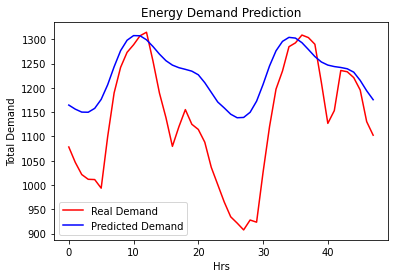

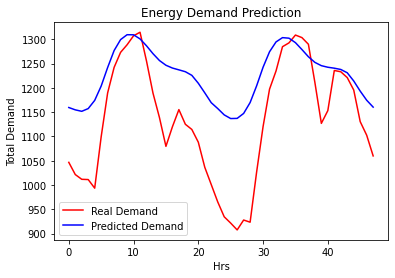

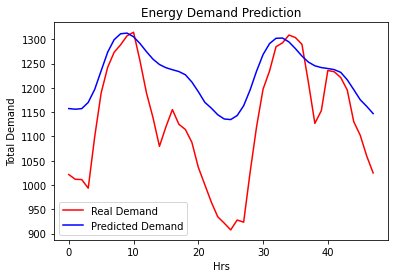

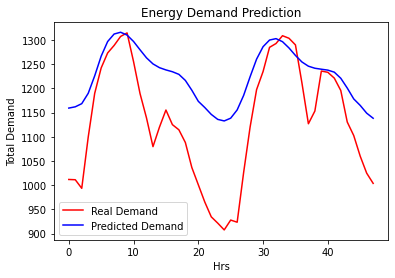

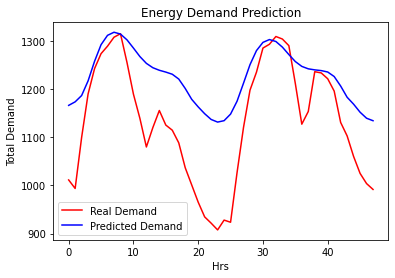

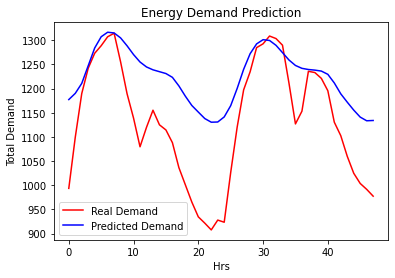

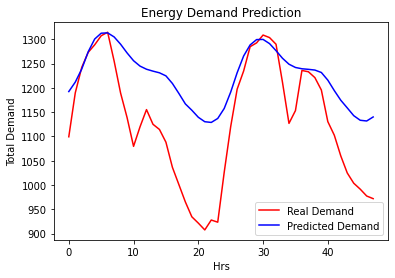

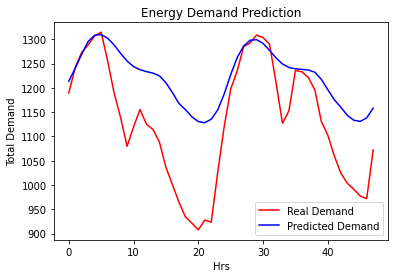

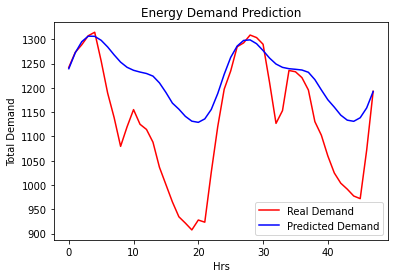

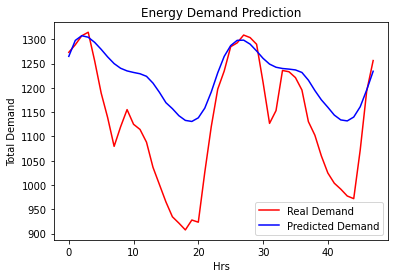

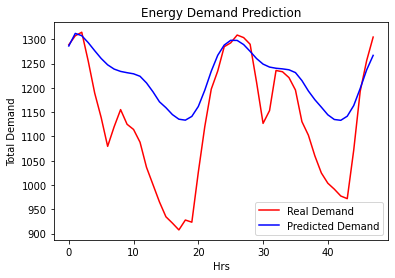

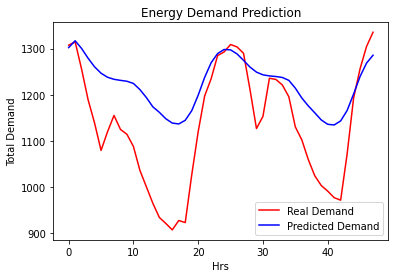

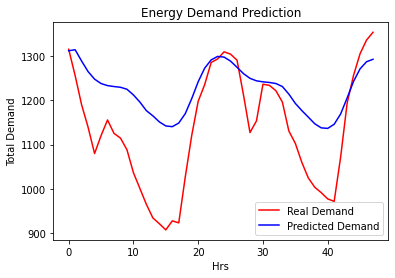

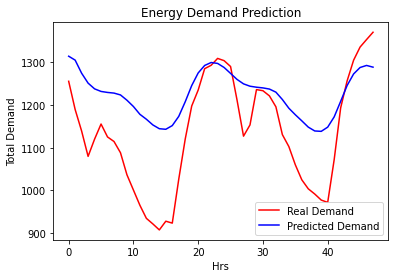

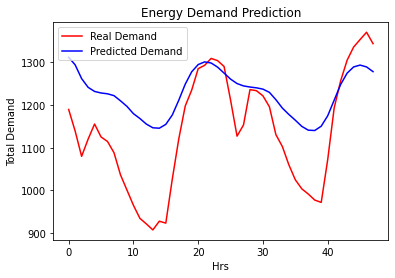

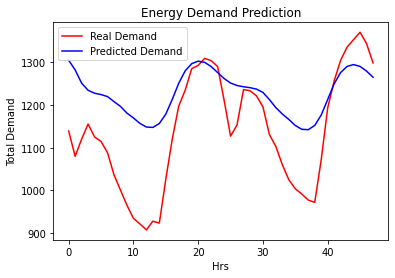

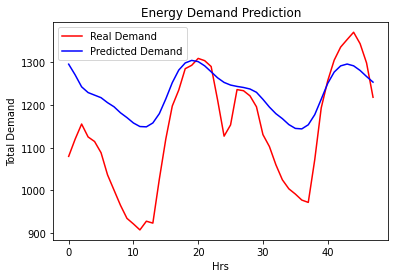

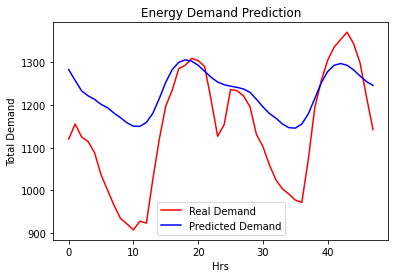

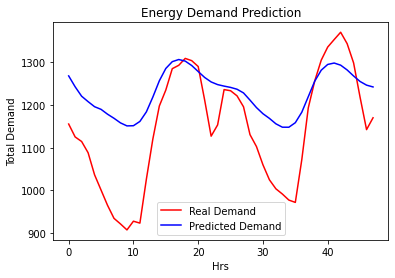

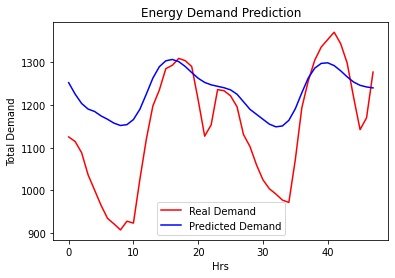

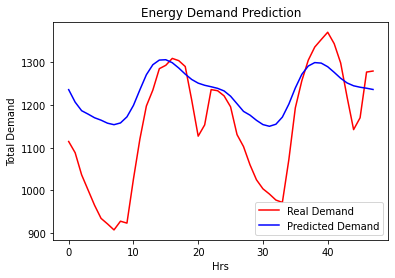

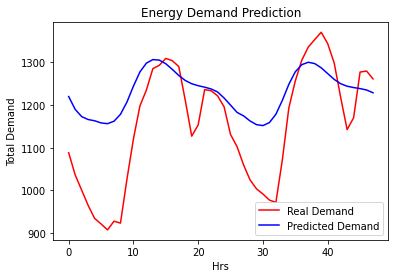

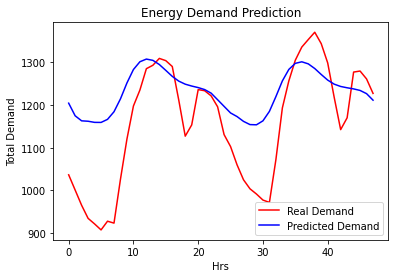

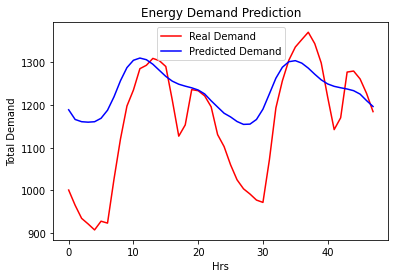

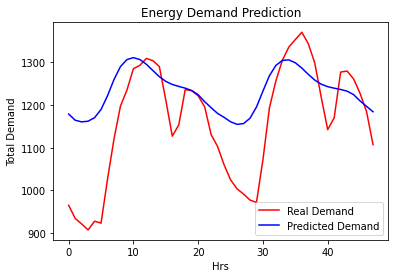

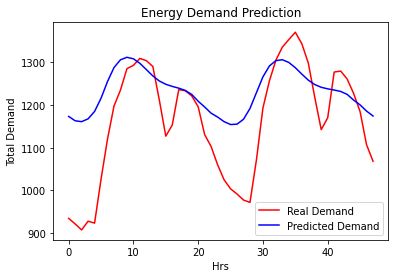

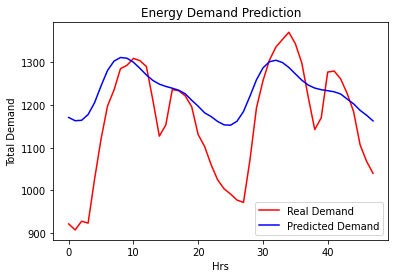

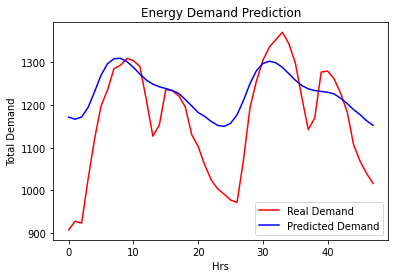

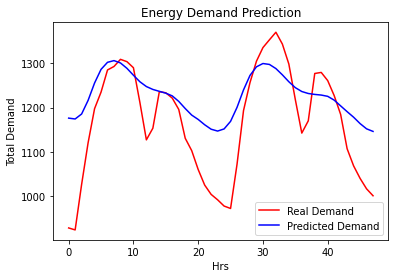

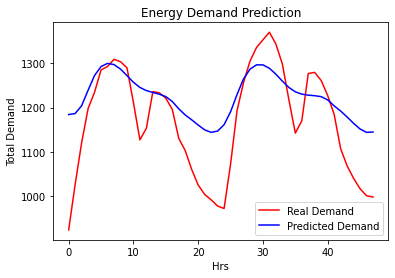

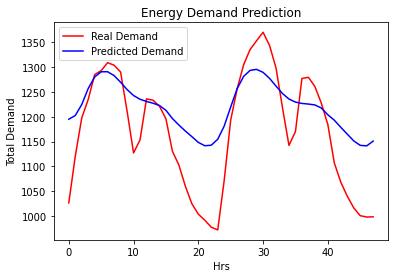

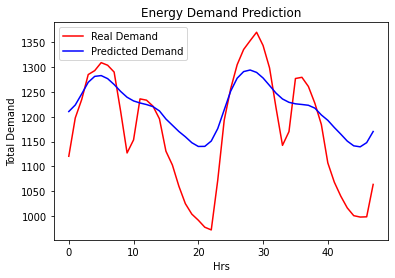

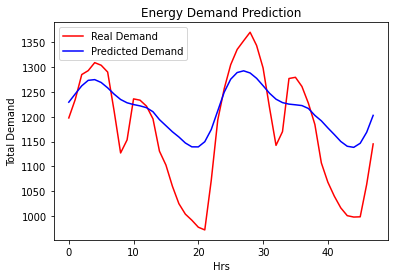

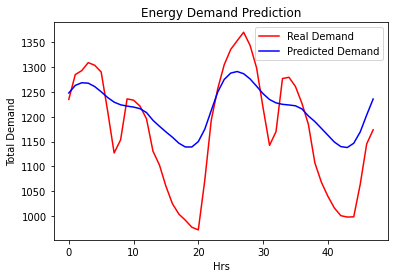

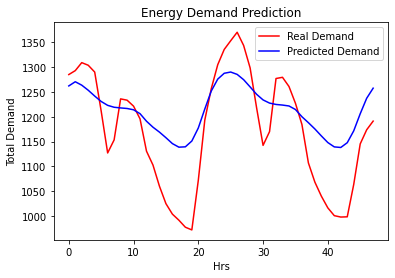

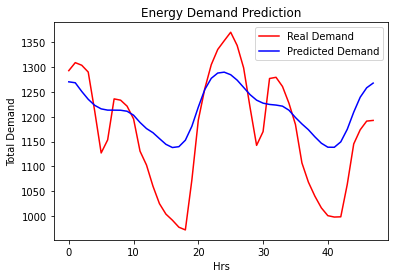

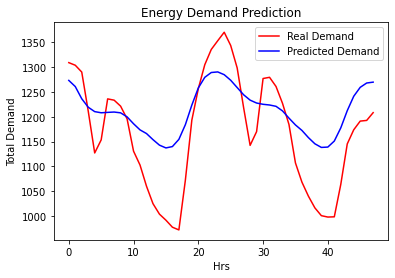

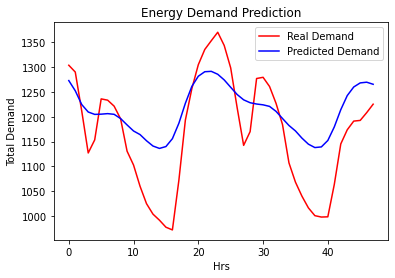

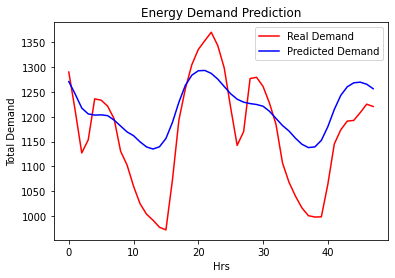

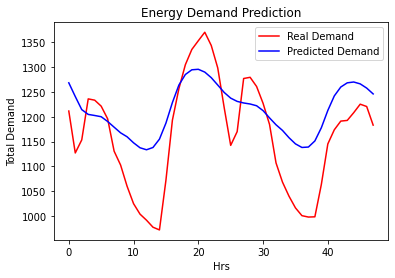

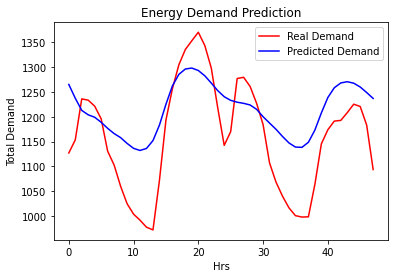

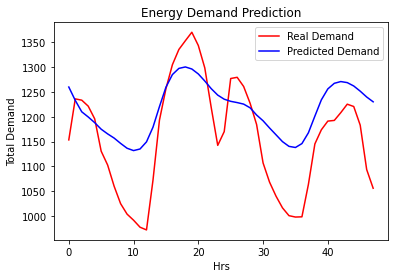

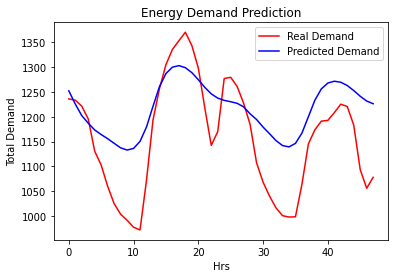

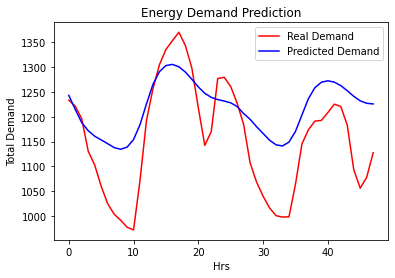

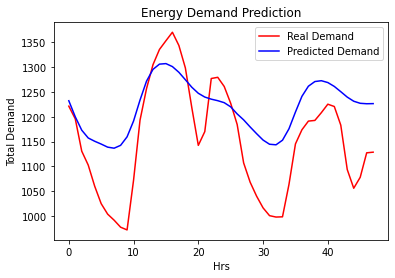

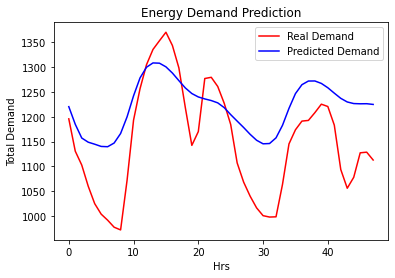

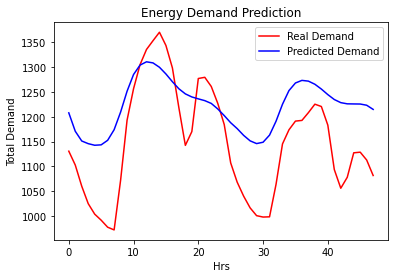

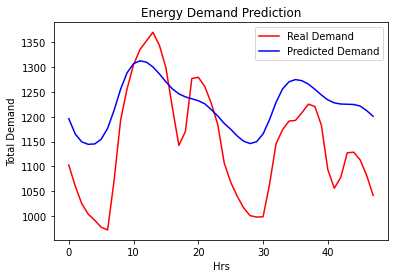

In [30]:
for index in range(Y_test.shape[0]):
        # print(Y_test[index,:,0:1],predicted_values[index,:,0:1])
        plt.plot(Y_test[index,:,0:1], color = 'red', label = 'Real Demand')
        plt.plot(predicted_values[index,:,0:1], color = 'blue', label = 'Predicted Demand')
        plt.title('Energy Demand Prediction')
        plt.xlabel('Hrs')
        plt.ylabel('Total Demand')
        plt.legend()
        plt.show()